In [9]:
import re
import os
import os
import re

import matplotlib.pyplot as plt
import pandas as pd

from utils.evaluations_utils import *
import numpy as np
# % matplotlib inline
import matplotlib
import seaborn as sns
from create_entropy_estimation import EntropyEstimation
import re
from typing import List, Iterable, Dict

plt.rcParams['figure.figsize'] = [10, 5]


In [10]:


def binary_ent(l, n):
    p = l / n
    return -((1 - p) * np.log2(1 - p) + (p) * np.log2(p))


def binomial_ent(l, n):
    p = l / n
    return (1. / 2.) * np.log(2 * np.pi * np.exp(1) * n * p * (1 - p)) / n


file_name_regex = re.compile('(ID_[0-9]+_[0-9]+)')


class CTWHandler():

    def __init__(self):
        self.__data = dict()

    def add_data(self, path: Iterable[str]):
        # data:List[cee.EntropyEstimation]=[]
        for i in path:
            data = EntropyEstimation.load(i)
            if data.tag not in self.__data:
                self.__data[data.tag] = dict()
            if data.file_name not in self.__data[data.tag]:
                self.__data[data.tag][data.file_name] = dict()
            self.__data[data.tag][data.file_name][data.file_index] = data

    def get_item_by_file_name_and_index(self, f_name, index):
        return {k: v[f_name][index] for k, v in self.__data.items()}

    def __len__(self):
        conter = 0
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                conter += len(vf)
        return conter

    def get_next_data(self):
        data_list = []
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                for ki, vi in vf.items():
                    data_list.append(vi)  #,tree=vi.tree)
        return data_list

    def __iter__(self):
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                for ki, vi in vf.items():
                    yield dict(tag=kt, file=kf, entropy=vi.entropy, rate=1000. * np.sum(vi.s) / vi.s.size,
                               n_spikes=np.sum(vi.s), l_segemnt=vi.s.size)  #sim_index=ki,,tree=vi.tree)

    def to_df(self, tag_regex_to_remove: str | List[str] = '', normelize_entropy=True,
              group_dict: Dict[str, str] | None = None):
        key_data_arr = dict(full_tag=[], tag=[], file=[], entropy=[], rate=[],
                            n_spikes=[], group=[], l_segemnt=[])  #sim_index=[], normalized_entropy=[])
        if isinstance(tag_regex_to_remove, str):
            tag_regex_to_remove = [tag_regex_to_remove]
        if group_dict is not None:
            group_dict = {k: re.compile(f'.*{v}.*') for k, v in group_dict.items()}
        for kv in self:
            for k, v in kv.items():
                if k == 'tag':
                    disp_v = v
                    for i in tag_regex_to_remove:
                        disp_v = re.sub(i, '', disp_v)
                    disp_v = re.sub('([0-9]+-[0-9]+)',
                                    lambda x: x.group(1).replace('-', '.') if x.group(1) is not None else None,
                                    disp_v)  # replacing to decimal point
                    key_data_arr['tag'].append(disp_v)

                    if group_dict is not None:
                        unique_flag = None
                        empty_flag = False
                        for k_group, v_group in group_dict.items():
                            if v_group.match(v):
                                key_data_arr['group'].append(k_group)
                                if unique_flag is None:
                                    unique_flag = True
                                else:
                                    unique_flag = False
                                empty_flag = True
                        assert unique_flag is None or unique_flag, 'Keys of group are not unique ' + v
                        assert empty_flag, 'one key has no group ' + v
                    else:
                        key_data_arr['group'].append('')
                    key_data_arr['full_tag'].append(v)
                elif k == 'file':
                    v = file_name_regex.match(v).group(1)
                    key_data_arr[k].append(v)
                else:
                    key_data_arr[k].append(v)
        df = pd.DataFrame(data=key_data_arr)

        return df

    def add_min_isi(self):

        data_arr = self.get_next_data()
        min_isi = {k: None for k in self.__data.keys()}
        for i in data_arr:
            indexes = np.where(i.s == 1)[0]
            cur_min_isi = np.min(indexes[1:] - indexes[:-1] - 1)
            if min_isi[i.tag] is None:
                min_isi[i.tag] = cur_min_isi
            elif min_isi[i.tag] > cur_min_isi:
                min_isi[i.tag] = cur_min_isi
        return min_isi

    def add_normalized(self, df, compress_to_minimal=False):
        min_isi_dict = self.add_min_isi()
        tags = df['full_tag']
        min_isi = np.array([min_isi_dict[t] for t in tags])
        print(f'min isi = {min_isi_dict}')
        if compress_to_minimal:
            df['normalizing_factor'] = binary_ent(df['n_spikes'], df['l_segemnt'] - (df['n_spikes'] * min_isi))
        else:
            df['normalizing_factor'] = binary_ent(df['n_spikes'], df['l_segemnt'] - (df['n_spikes'] * min_isi))
        df['normalized_entropy'] = df['entropy'] / df['normalizing_factor']


In [11]:

models = {}
regex_match = re.compile('Rat.+CTW')
#regex_match = re.compile('test')
gmax_regex = re.compile('.*_([0-9](?:-[0-9])?(?:_noNMDA)?)_.*')
gmax_value_regex = re.compile('([0-9](?:\.[0-9])?)[a-z,A-Z]*')
models_pathes = []
for i in os.listdir('entropy_data'):

    cur_dir_path = os.path.join('entropy_data', i)
    if regex_match.match(i) and os.path.isdir(cur_dir_path):
        for j in os.listdir(cur_dir_path):
            models_pathes.append(os.path.join(cur_dir_path, j))

name_order = list(models.values())
name_order = sorted(name_order, key=lambda x: (float(gmax_value_regex.match(x).group(0)), 'AMPA' not in x))

remove_v = True

In [27]:

c = CTWHandler()
c.add_data(models_pathes)
df = c.to_df(tag_regex_to_remove=['Rat_L5b_PC_2_Hay_', '_noNMDA', '_CTW'],
             group_dict={'NMDA': 'Hay_(?:[0-9]-)?[0-9]_CTW', 'AMPA': '_noNMDA'})
for i in df['full_tag'].unique():
    df.loc[df['full_tag'] == i, 'average_rate'] = np.round(df.loc[df['full_tag'] == i, 'rate'].mean(), 2)

get_factor_from_tag_match = re.compile('(?:.*_)?([0-9](?:\.[0-9]+)?).*')


def convert_tag_to_float(x):
    a=get_factor_from_tag_match.match(x).group(1)
    print(x,a)
    return float(a)


df['factor'] = df['tag'].apply(convert_tag_to_float)

factor_order = {i: convert_tag_to_float(i) for i in df['tag'].unique()}

0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.4 0.4
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6
0.6 0.6


In [28]:
c.add_normalized(df, False)

min isi = {'Rat_L5b_PC_2_Hay_0-4_CTW': 5, 'Rat_L5b_PC_2_Hay_0-4_noNMDA_CTW': 7, 'Rat_L5b_PC_2_Hay_0-6_CTW': 5, 'Rat_L5b_PC_2_Hay_0-6_noNMDA_CTW': 6, 'Rat_L5b_PC_2_Hay_0-8_CTW': 5, 'Rat_L5b_PC_2_Hay_0-8_noNMDA_CTW': 6, 'Rat_L5b_PC_2_Hay_1-2_CTW': 4, 'Rat_L5b_PC_2_Hay_1-2_noNMDA_CTW': 5, 'Rat_L5b_PC_2_Hay_1-4_CTW': 4, 'Rat_L5b_PC_2_Hay_1-4_noNMDA_CTW': 5, 'Rat_L5b_PC_2_Hay_1-6_CTW': 3, 'Rat_L5b_PC_2_Hay_1-6_noNMDA_CTW': 5, 'Rat_L5b_PC_2_Hay_1-8_CTW': 3, 'Rat_L5b_PC_2_Hay_1-8_noNMDA_CTW': 5, 'Rat_L5b_PC_2_Hay_1_CTW': 4, 'Rat_L5b_PC_2_Hay_1_noNMDA_CTW': 5, 'Rat_L5b_PC_2_Hay_noNMDA_2-5_CTW': 5, 'Rat_L5b_PC_2_Hay_2_CTW': 4, 'Rat_L5b_PC_2_Hay_2_noNMDA_CTW': 5, 'Rat_L5b_PC_2_Hay_noNMDA_3-5_CTW': 5, 'Rat_L5b_PC_2_Hay_noNMDA_3_CTW': 5, 'Rat_L5b_PC_2_Hay_noNMDA_4-5_CTW': 4, 'Rat_L5b_PC_2_Hay_noNMDA_4_CTW': 4, 'Rat_L5b_PC_2_Hay_noNMDA_5_CTW': 4}


[Text(0.5, 1.0, 'Entropy as function of factor and rate')]

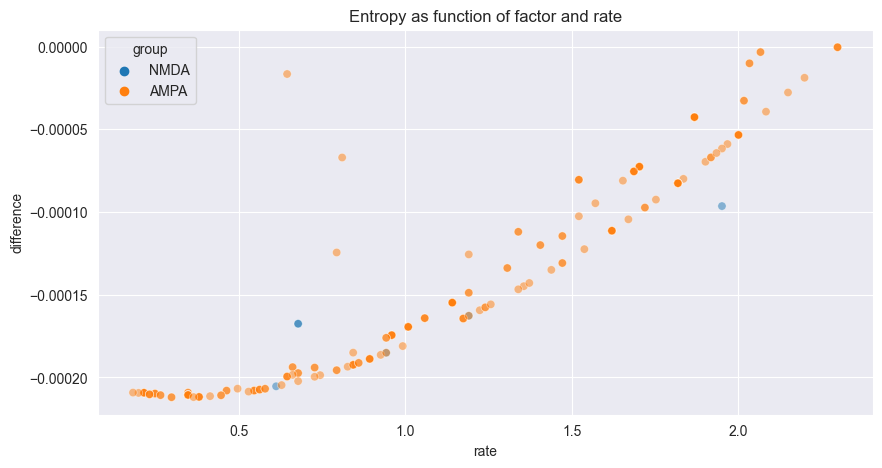

In [29]:
#maximum entropy vs the value itself
temp_df = df.copy()
temp_df['difference'] = df['normalizing_factor'] - df['entropy']
temp_df = temp_df[temp_df['difference'] < 0]
sns.scatterplot(data=temp_df, x="rate", y="difference", hue="group", sizes=(5, 200), alpha=0.5).set(
    title='Entropy as function of factor and rate')


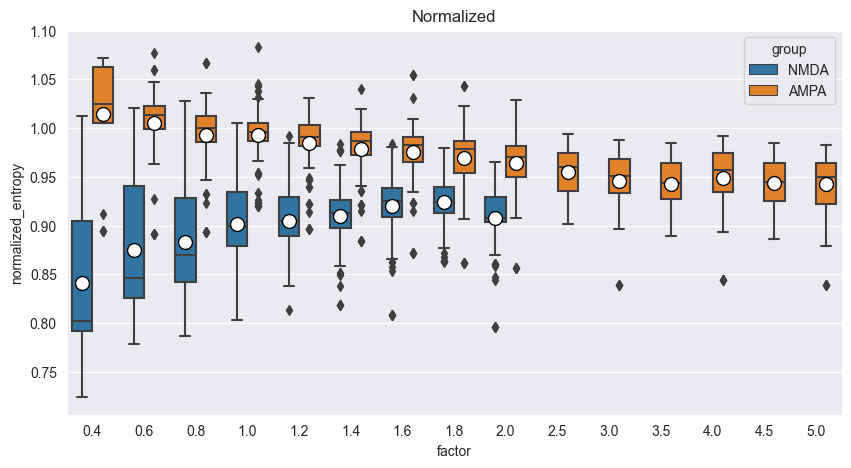

[Text(0.5, 1.0, 'Original')]

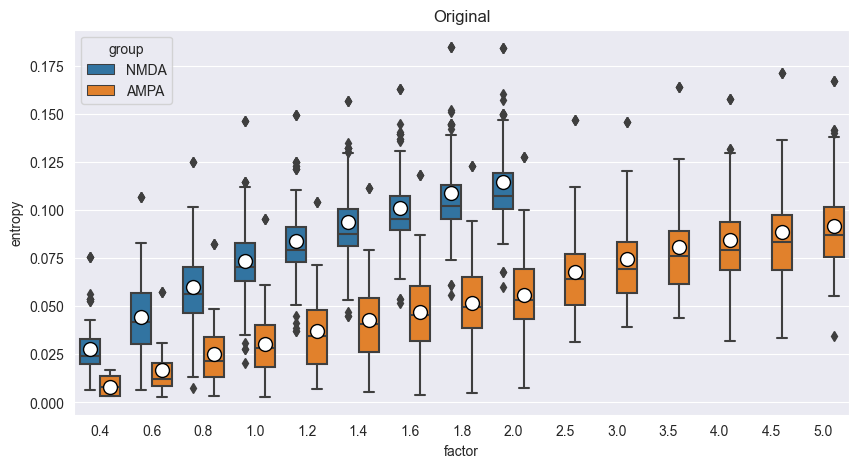

In [30]:


#show the dis

# Draw a nested boxplot to show bills by day and time

sns.boxplot(x="factor", y="normalized_entropy", data=df, hue='group', showmeans=True, meanprops={"marker": "o",
                                                                                                 "markerfacecolor": "white",
                                                                                                 "markeredgecolor": "black",
                                                                                                 "markersize": "10"}).set(
    title='Normalized')
plt.show()

sns.boxplot(x="factor", y="entropy", data=df, showmeans=True, hue='group', meanprops={"marker": "o",
                                                                                      "markerfacecolor": "white",
                                                                                      "markeredgecolor": "black",
                                                                                      "markersize": "10"}).set(
    title='Original')
# sns.despine(offset=10, trim=True)

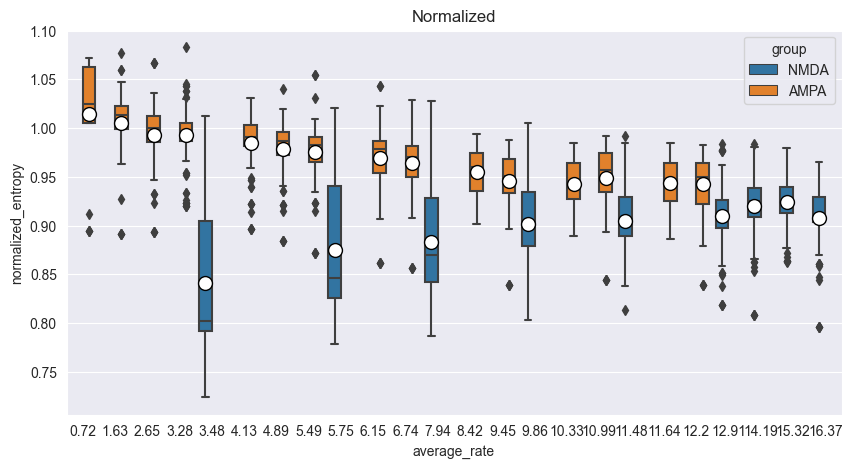

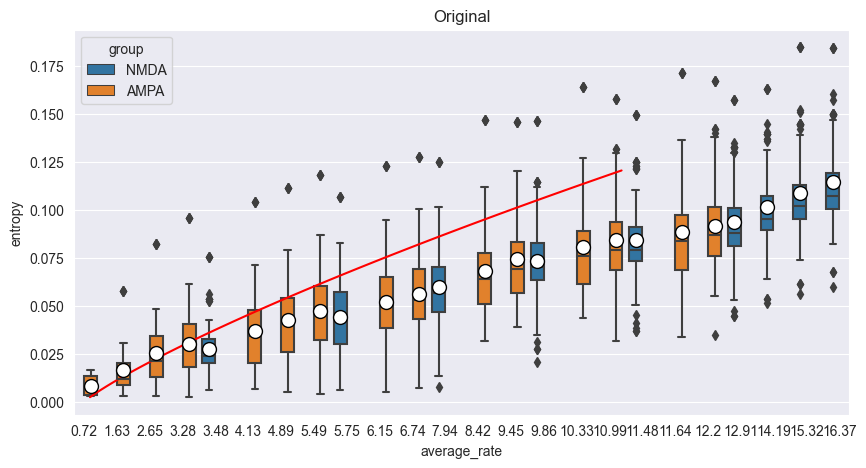

In [31]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="average_rate", y="normalized_entropy", data=df, hue='group', showmeans=True, meanprops={"marker": "o",
                                                                                                       "markerfacecolor": "white",
                                                                                                       "markeredgecolor": "black",
                                                                                                       "markersize": "10"}).set(
    title='Normalized')
plt.show()
x = np.linspace(df['rate'].min(), df['average_rate'].max(), 100)
l = df['l_segemnt'].mean()
# plt.plot(x,[binary_ent()(i*l,l)for i in x],color='red')
fig, ax = plt.subplots()
sns.boxplot(x="average_rate", y="entropy", data=df, showmeans=True, hue='group', meanprops={"marker": "o",
                                                                                            "markerfacecolor": "white",
                                                                                            "markeredgecolor": "black",
                                                                                            "markersize": "10"},
            ax=ax).set(title='Original')
ax.plot(x, [binary_ent(i * l / 1000., l) for i in x], color='red')


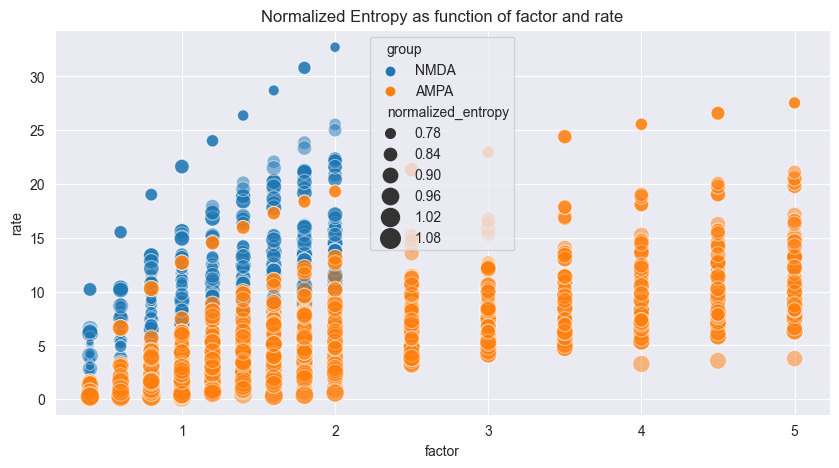

[Text(0.5, 1.0, 'Entropy as function of factor and rate')]

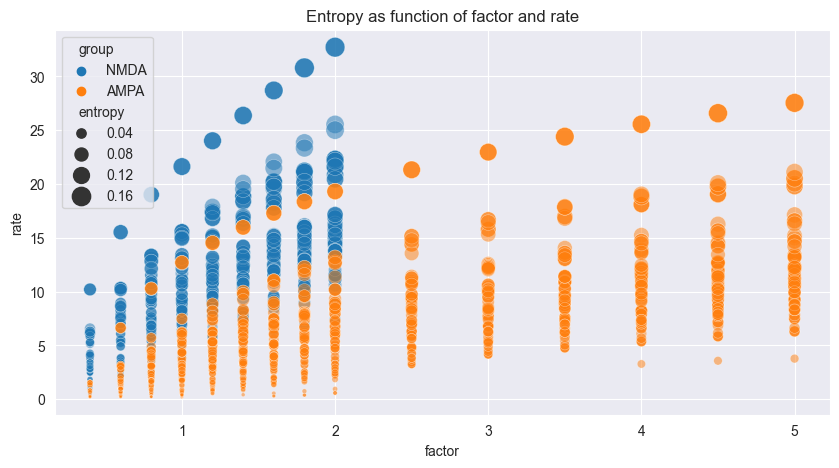

In [32]:
#factor as function of rate
temp_df = df.copy()
temp_df['normalized_entropy'] = temp_df['normalized_entropy'].apply(lambda x: float(x))
temp_df['entropy'] = temp_df['entropy'].apply(lambda x: float(x))

# temp_df['tag']=temp_df['tag'].apply(lambda x:float(x))

sns.scatterplot(data=temp_df, x="factor", y="rate", hue="group", size='normalized_entropy', sizes=(20, 200),
                alpha=0.5).set(title='Normalized Entropy as function of factor and rate')
plt.show()
sns.scatterplot(data=temp_df, x="factor", y="rate", hue="group", size='entropy', sizes=(5, 200), alpha=0.5).set(
    title='Entropy as function of factor and rate')

<AxesSubplot: xlabel='entropy', ylabel='normalized_entropy'>

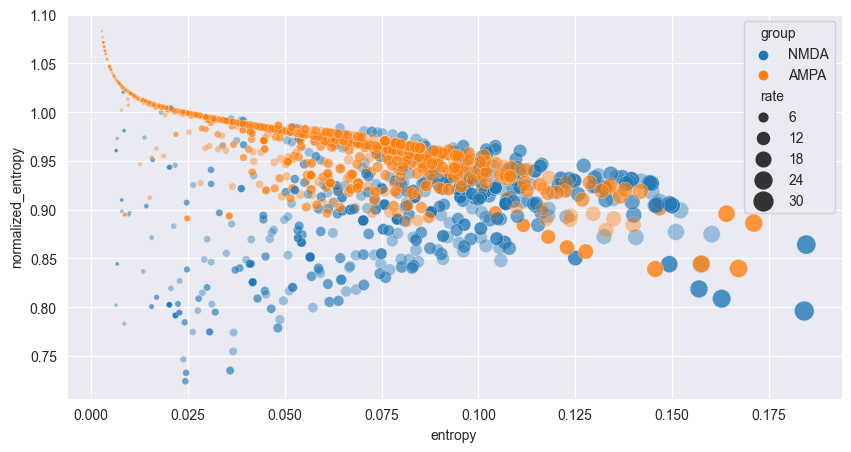

In [33]:
sns.scatterplot(data=temp_df, x="entropy", y="normalized_entropy", hue="group", size='rate', sizes=(5, 200), alpha=0.4)

In [34]:
#print avarage diffs
def get_entropies_by_group(group: str):
    data_dict = dict()
    # order={k:v for v,k in enumerate(df['tag'].unique().tolist())}
    order = sorted(df['tag'].unique().tolist(), key=lambda x: float(x.replace('-', '.')))

    # temp_df = df.sort_values(by=['file'])
    for index, row in df.iterrows():
        if group != row.group:
            continue
        if row.file not in data_dict:
            data_dict[row.file] = dict()
        if row.tag not in data_dict[row.file]:
            data_dict[row.file][row.tag] = dict()

        data_dict[row.file][row.tag]['normalized'] = row.normalized_entropy
        data_dict[row.file][row.tag]['original'] = row.entropy

    normalize_arr = np.zeros((len(data_dict), len(order)))
    original_arr = np.zeros((len(data_dict), len(order)))
    x = []
    x_flag = True
    for j, d_t in enumerate(data_dict.values()):
        for i, t in enumerate(order):
            if x_flag:
                x.append(i)
            if not t in d_t:
                normalize_arr[j, i] = (np.NAN)
                original_arr[j, i] = (np.NAN)
            else:
                normalize_arr[j, i] = (d_t[t]['normalized'])
                original_arr[j, i] = (d_t[t]['original'])
        x_flag = False
    return normalize_arr, original_arr, x, order


def z_score_f(mat, ax=1):
    min_value = np.nanmin(mat, axis=ax)
    max_value = np.nanmax(mat, axis=ax)
    if ax == 1:
        min_value = min_value[:, np.newaxis]
        max_value = max_value[:, np.newaxis]
    return (mat - min_value) / (max_value - min_value)


def plot_by_group(group):
    normalize_color = np.array([0., 0., 1.])
    original_color = np.array([1., 0., 0.])

    normalize_arr, original_arr, x, order = get_entropies_by_group(group)
    fig, ax = plt.subplots(4, gridspec_kw={'height_ratios': [15, 15, 15, 1]})
    fig.suptitle(group)
    ax[0].plot(x, normalize_arr.T, c=normalize_color, alpha=0.1)
    ax[0].plot(x, original_arr.T, c=original_color, alpha=0.1)
    ax[0].set_title('entropy as function of factor')
    ax[0].set_xticks(np.arange(len(order)), order)

    ax[1].set_title('Z Score Entropy')
    ax[1].plot(x, z_score_f(normalize_arr.T, 0), c=normalize_color, alpha=0.1)
    ax[1].plot(x, z_score_f(original_arr.T, 0), c=original_color, alpha=0.1)
    ax[1].plot([], [], c=normalize_color, label='Normalized Entropy')
    ax[1].plot([], [], c=original_color, label='Entropy')
    ax[1].plot([], [], c=normalize_color / 2, label='Normalized Entropy mean')
    ax[1].plot([], [], c=original_color / 2, label='Entropy mean')
    ax[1].set_xlabel('factor')
    ax[1].set_xticks(np.arange(len(order)), order)
    ax[1].plot(x, np.nanmean(z_score_f(normalize_arr.T, ax=0), axis=1), c=normalize_color / 2,
               label='Normalized Entropy')
    ax[1].plot(x, np.nanmean(z_score_f(original_arr.T, ax=0), axis=1), c=original_color / 2, label='Entropy')

    normalize_mean = np.nanmean((normalize_arr.T), axis=1)
    original_mean = np.nanmean((original_arr.T), axis=1)
    ax[2].set_title('Derivative')
    ax[2].plot(normalize_mean[1:] - normalize_mean[:-1], c=normalize_color, label='Normalized Entropy')
    ax[2].plot(original_mean[1:] - original_mean[:-1], c=original_color, label='Entropy')
    ax[2].set_xticks([], [])
    plt.tight_layout()

    ax[3].plot([], [], c=normalize_color, label='Normalized Entropy')
    ax[3].plot([], [], c=original_color, label='Entropy')
    ax[3].legend()
    ax[3].set_xticks([], [])
    ax[3].set_yticks([], [])
    # return ax

In [35]:
plot_by_group('NMDA')

ValueError: could not convert string to float: 'noNMDA_2.5'

In [36]:
plot_by_group('AMPA')

ValueError: could not convert string to float: 'noNMDA_2.5'